<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#データ生成" data-toc-modified-id="データ生成-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>データ生成</a></span></li><li><span><a href="#平坦事前分布の場合" data-toc-modified-id="平坦事前分布の場合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>平坦事前分布の場合</a></span></li><li><span><a href="#正規事前分布の場合" data-toc-modified-id="正規事前分布の場合-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>正規事前分布の場合</a></span></li></ul></div>

# Bayesian Poisson回帰

* 黒木玄
* 2020-09-16

Bayesian Poisson回帰と最尤法(+ Wald検定で使う正規分布近似)によるPoisson回帰の結果が近似的に一致することを数値的に確認する.

In [1]:
using Distributions
using Optim
using Random
Random.seed!(4649373)
using StaticArrays
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10)
using Turing

In [2]:
# 最尤推定 + Wald法で使う正規分布近似のβとβ̂の役割を交換したもの

function mvnormal_approx_posterior(x, y)
    λ(β₀, β₁, xᵢ) = exp(β₀ + β₁*xᵢ)
    f(w) = -sum(logpdf(Poisson(λ(w[1], w[2], x)), y) for (x, y) in zip(x, y))
    o = optimize(f, zeros(2), LBFGS())
    β̂₀, β̂₁ = β̂ = o.minimizer # maximum likelihood estimate
    λ̂(i) = λ(β̂₀, β̂₁, x[i])
    â = sum(λ̂(i) for i in eachindex(x))
    b̂ = sum(λ̂(i)*x[i] for i in eachindex(x))
    ĉ = sum(λ̂(i)*x[i]^2 for i in eachindex(x))
    Î = SMatrix{2,2}(â, b̂, b̂, ĉ) # Fisher information at β̂
    MvNormal(β̂, inv(Î)) # mvnormal approximation of the posterior of β
end

mvnormal_approx_posterior (generic function with 1 method)

## データ生成

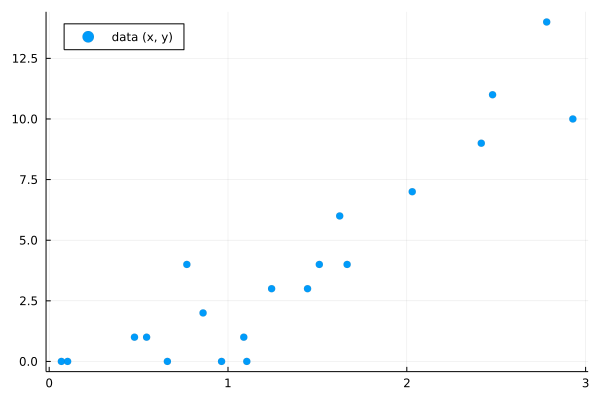

In [3]:
n = 20
x = sort(rand(Uniform(0, 3), n))
β₀, β₁ = -0.2, 1.0
pois = @. Poisson(exp(β₀ + β₁*x))
y = rand.(pois)
scatter(x, y; label="data (x, y)", msw=0, legend=:topleft)

## 平坦事前分布の場合

In [4]:
@model function poissonreg(x, y)
    β₀ ~ Turing.Flat()
    β₁ ~ Turing.Flat()
    for i in eachindex(x, y)
        y[i] ~ Poisson(exp(β₀ + β₁*x[i]))
    end
end

poissonreg (generic function with 2 methods)

In [5]:
chn = sample(poissonreg(x, y), NUTS(), MCMCThreads(), 10^5, 3);

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191


In [6]:
chn

Chains MCMC chain (100000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 3
Samples per chain = 100000
Wall duration     = 17.27 seconds
Compute duration  = 48.45 seconds
parameters        = β₀, β₁
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          β₀   -0.5650    0.3253     0.0006    0.0014   55834.5046    1.0000   ⋯
          β₁    1.1177    0.1445     0.0003    0.0006   56037.4242    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 



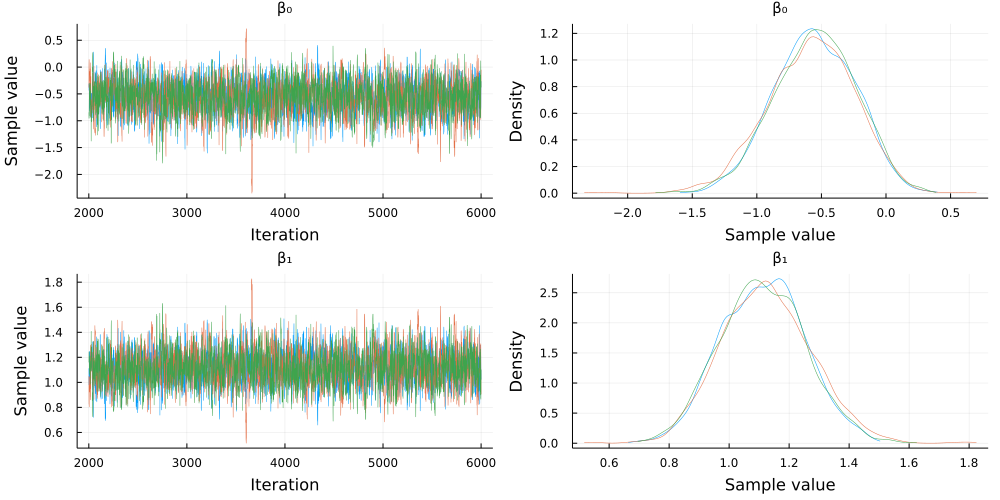

In [7]:
plot(chn[1001:5000]; lw=0.5, leftmargin=4Plots.mm, bottommargin=4Plots.mm)

In [8]:
B0, B1 = vec(chn[:β₀]), vec(chn[:β₁])

([-0.8839927581722167, -0.5224719589521832, -0.37388536890741053, -0.2838300280447616, -0.2838300280447616, -0.5285718770636876, -0.6383714349342545, -0.7714843355363193, -0.7714843355363193, -0.7676685053893857  …  -0.26198534676299734, -0.20998296828357044, -0.27002424651319207, -0.20095162782941867, -0.8024833847378968, -0.3018363960594729, -0.5501409334738192, -0.44780785988491956, -0.5257372549623309, -0.46636034790258707], [1.1884437750974035, 1.0254368471691222, 1.087916497374175, 1.0265476107920253, 1.0265476107920253, 1.202397445137879, 1.1017817142721684, 1.2303420935467155, 1.2303420935467155, 1.2040488625877726  …  1.021552032643604, 1.0340664706420448, 1.0161343034963934, 0.9322925825757924, 1.1565494918131813, 1.0303843088012337, 1.098971619578625, 1.075114318597198, 1.0594534338206736, 1.0784381907885991])

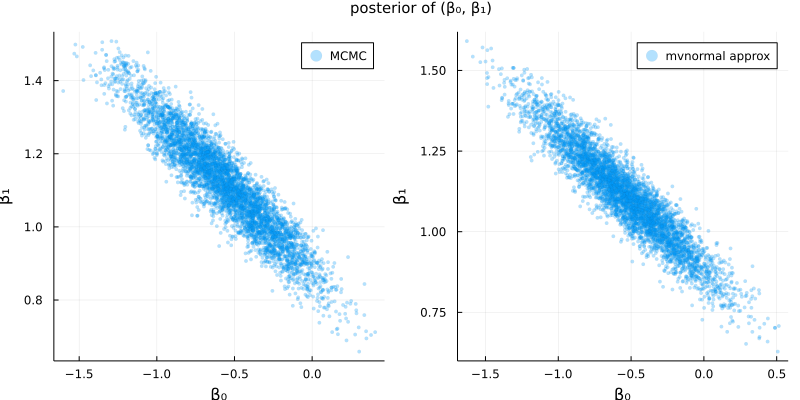

In [9]:
mvnormal_approx = mvnormal_approx_posterior(x, y)
m = 5000
MV = rand(mvnormal_approx, m)
P1 = scatter(B0[1:m], B1[1:m]; label="MCMC", ms=2, msw=0, alpha=0.3)
plot!(xguide="β₀", yguide="β₁")
P2 = scatter(MV[1,:], MV[2,:]; label="mvnormal approx", ms=2, msw=0, alpha=0.3)
plot!(xguide="β₀", yguide="β₁")
plot(P1, P2; size=(800, 400), plot_title="posterior of (β₀, β₁)")

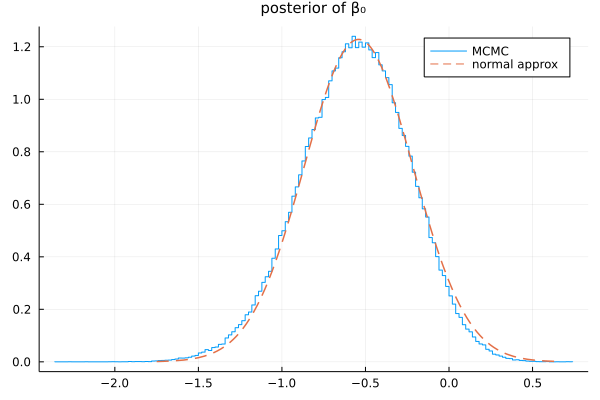

In [10]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx0 = Normal(β̂[1], √Σ̂[1,1])
stephist(B0; norm=true, label="MCMC")
plot!(normal_approx0; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₀")

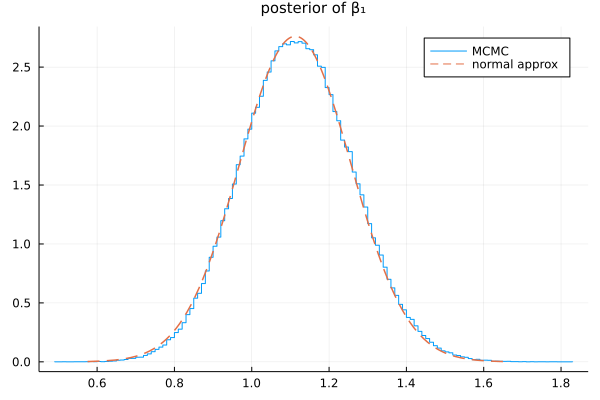

In [11]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx1 = Normal(β̂[2], √Σ̂[2,2])
stephist(B1; norm=true, label="MCMC")
plot!(normal_approx1; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₁")

## 正規事前分布の場合

In [12]:
@model function poissonreg_normalprior(x, y)
    β₀ ~ Normal(0, 2)
    β₁ ~ Normal(0, 2)
    for i in eachindex(x, y)
        y[i] ~ Poisson(exp(β₀ + β₁*x[i]))
    end
end

poissonreg_normalprior (generic function with 2 methods)

In [13]:
chn_np = sample(poissonreg_normalprior(x, y), NUTS(), MCMCThreads(), 10^5, 3);

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference D:\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191


In [14]:
chn_np

Chains MCMC chain (100000×14×3 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 3
Samples per chain = 100000
Wall duration     = 11.62 seconds
Compute duration  = 34.62 seconds
parameters        = β₀, β₁
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          β₀   -0.5401    0.3208     0.0006    0.0012   67917.2276    1.0001   ⋯
          β₁    1.1069    0.1428     0.0003    0.0005   68159.1346    1.0001   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 



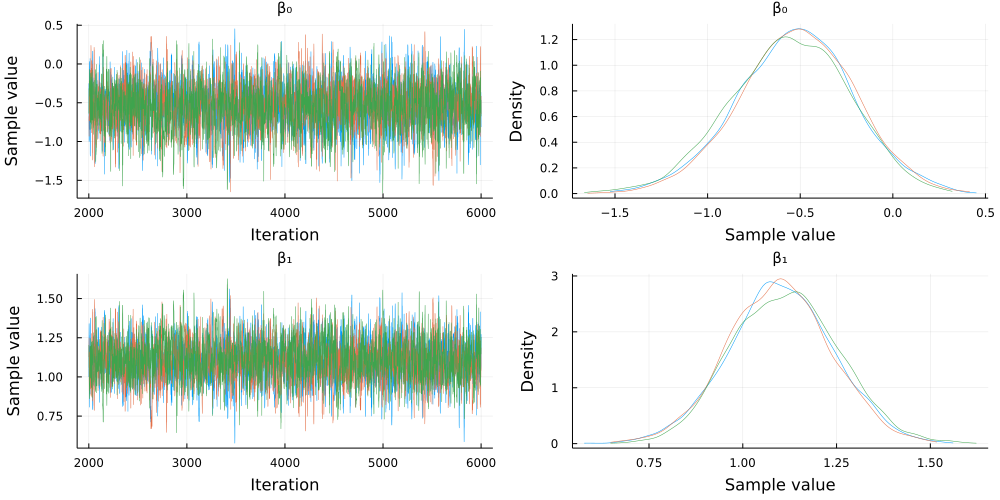

In [15]:
plot(chn_np[1001:5000]; lw=0.5, leftmargin=4Plots.mm, bottommargin=4Plots.mm)

In [16]:
B0, B1 = vec(chn_np[:β₀]), vec(chn_np[:β₁])

([-0.8962182369006391, -0.8481627299626547, -0.5070362360035121, -0.6171940077867597, -0.5732159556203758, -0.5444053665916933, 0.06426628679953211, 0.010879707470071512, 0.010879707470071512, -0.12350307071211004  …  -0.777092651594256, -0.6685065402154189, -0.9192199234890648, -0.9382186885138486, -0.9111801170038076, -0.4881868089339084, -0.8081054773721295, -0.2753321068212379, -0.4296271580568492, -0.24432049841314063], [1.2213638934468425, 1.1930525744302456, 1.1092073697914162, 1.168063816105819, 1.148486375566998, 1.1700074630108601, 0.8719355213780402, 0.9087024965687093, 0.9087024965687093, 0.9672314386788763  …  1.2418068033552687, 1.1422993904528778, 1.3037303489633887, 1.257157576774485, 1.2788497438690252, 1.1008966811566907, 1.2401414160509112, 0.9825326318746401, 1.0626261263037298, 0.9809028067363276])

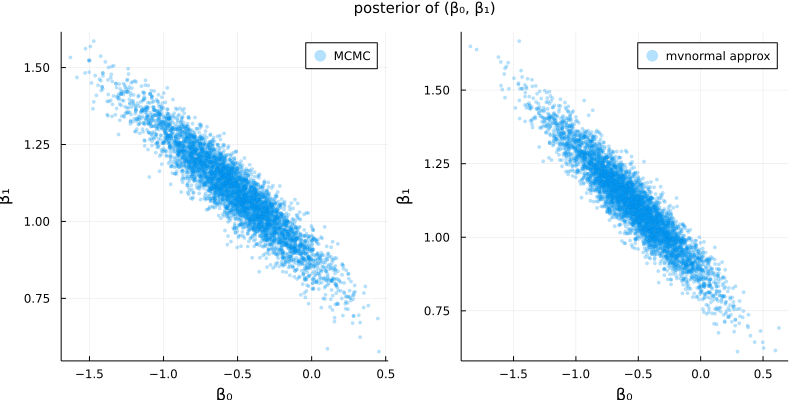

In [17]:
mvnormal_approx = mvnormal_approx_posterior(x, y)
m = 5000
MV = rand(mvnormal_approx, m)
P1 = scatter(B0[1:m], B1[1:m]; label="MCMC", ms=2, msw=0, alpha=0.3)
plot!(xguide="β₀", yguide="β₁")
P2 = scatter(MV[1,:], MV[2,:]; label="mvnormal approx", ms=2, msw=0, alpha=0.3)
plot!(xguide="β₀", yguide="β₁")
plot(P1, P2; size=(800, 400), plot_title="posterior of (β₀, β₁)")

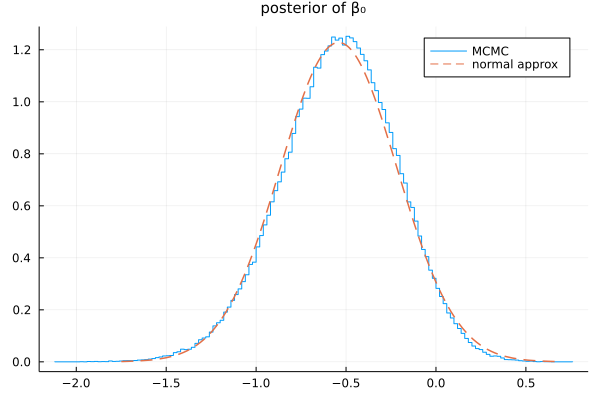

In [18]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx0 = Normal(β̂[1], √Σ̂[1,1])
stephist(B0; norm=true, label="MCMC")
plot!(normal_approx0; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₀")

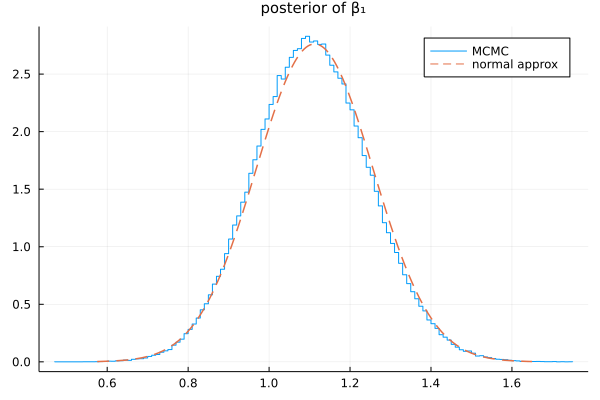

In [19]:
β̂, Σ̂ = params(mvnormal_approx)
normal_approx1 = Normal(β̂[2], √Σ̂[2,2])
stephist(B1; norm=true, label="MCMC")
plot!(normal_approx1; label="normal approx", ls=:dash, lw=1.5)
title!("posterior of β₁")